In [3]:
# !pip install psycopg2-binary

  Obtaining dependency information for psycopg2-binary from https://files.pythonhosted.org/packages/7a/1f/a6cf0cdf944253f7c45d90fbc876cc8bed5cc9942349306245715c0d88d6/psycopg2_binary-2.9.9-cp311-cp311-macosx_11_0_arm64.whl.metadata
Using cached psycopg2_binary-2.9.9-cp311-cp311-macosx_11_0_arm64.whl (2.6 MB)


In [9]:
import os

import psycopg2 as ppg
import pandas as pd
import numpy as np

import plotly.express as plx
import matplotlib.pyplot as plt
import seaborn as sns

from dotenv import load_dotenv

import warnings

warnings.filterwarnings('ignore')

In [25]:
load_dotenv('.env')
with ppg.connect(database='Books_', user=os.getenv('USER'), password=os.getenv("PASSWORD")) as conn:
    query = """
    SELECT * FROM books;
    """
    data = pd.read_sql(query, con=conn)

In [26]:
data.head()

,id,title,author,category,description,publisher,rating,votes
0,3026024,Полюбить учителя главного героя,23292617,110005,Девятнадцать лет назад Ли Ляньхуа была обвинен...,125802,0.00,0
1,3017556,Колесо года. Календарь магических дел и праздн...,544946,110206,"Отмечайте поворотные точки года, чтобы усилива...",154486,3.67,3
2,3018451,Иди за рекой: роман,23227165,110002,Виктория случайно встречается с Уилом на улице...,118732,4.80,5
3,3008442,Память душ,5154296,110005,Третья часть цикла эпического фэнтези «Хор дра...,108913,4.80,5
4,3009489,Человек-паук. Время славы. Том 3,490688,110063,Время славы продолжается!\n\nЧеловек-паук объе...,154486,4.08,13


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445822 entries, 0 to 445821
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           445822 non-null  int64  
 1   title        445822 non-null  object 
 2   author       445822 non-null  int64  
 3   category     445822 non-null  int64  
 4   description  445822 non-null  object 
 5   publisher    445822 non-null  int64  
 6   rating       445822 non-null  float64
 7   votes        445822 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 27.2+ MB


In [29]:
data.id = data.id.astype(np.int32)
data.author = data.author.astype(np.int32)
data.category = data.category.astype(np.int32)
data.publisher = data.publisher.astype(np.int32)
data.votes = data.votes.astype(np.int16)
data.rating = data.rating.astype(np.float16)

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445822 entries, 0 to 445821
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           445822 non-null  int32  
 1   title        445822 non-null  object 
 2   author       445822 non-null  int32  
 3   category     445822 non-null  int32  
 4   description  445822 non-null  object 
 5   publisher    445822 non-null  int32  
 6   rating       445822 non-null  float16
 7   votes        445822 non-null  int16  
dtypes: float16(1), int16(1), int32(4), object(2)
memory usage: 15.3+ MB


In [31]:
data.author.nunique(), data.category.nunique(), data.publisher.nunique()

(85737, 329, 5003)

In [32]:
data.drop(columns='title').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445822 entries, 0 to 445821
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           445822 non-null  int32  
 1   author       445822 non-null  int32  
 2   category     445822 non-null  int32  
 3   description  445822 non-null  object 
 4   publisher    445822 non-null  int32  
 5   rating       445822 non-null  float16
 6   votes        445822 non-null  int16  
dtypes: float16(1), int16(1), int32(4), object(1)
memory usage: 11.9+ MB


In [35]:
with ppg.connect(database='Books_', user=os.getenv('USER'), password=os.getenv("PASSWORD")) as conn:
    query = """
    SELECT * FROM category;
    """
    category = pd.read_sql(query, con=conn, index_col='id')

In [36]:
category

,title
id,
0,ND
110005,Фэнтези
110028,Публицистика
110020,Деятели культуры и искусства
110011,Детективный роман. Триллер
...,...
110159,Другие общественные предметы
110172,"ЕГЭ, ОГЭ, ВПР"
110376,Страхование. Социальная работа


In [40]:
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy

In [38]:
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

stop_words = stopwords.words('english')
stop_words.append('Tesla')

from gensim import corpora
from gensim.models import TfidfModel
from gensim import similarities

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/alexandernazimov/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alexandernazimov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alexandernazimov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexandernazimov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:
lemm = WordNetLemmatizer()

In [53]:
def flat_generator(list_):
    for elem in list_:
        for el in elem:
            yield el

In [90]:
def cos_sim_df(data: pd.Series):
    t = []
    for line in data:
        sents = sent_tokenize(line)
        s = []
        for i, sent in enumerate(sents):
            token = word_tokenize(sent)
            token = [i for i in token if (i not in stop_words)]
            token = [lemm.lemmatize(t) for t in token]
            token = [t.lower() for t in token]
            s.append(token)
        t.append([tok for tok in flat_generator(s)])

    dictionary = corpora.Dictionary(t)
    dict(dictionary)

    bows = [dictionary.doc2bow(text) for text in t]

    tfidf = TfidfModel(bows)

    cos_sim = similarities.MatrixSimilarity(tfidf[bows])
    return pd.DataFrame(list(cos_sim))

In [346]:
def csd(data):    
    c = cos_sim_df(category['title'])
    clusters = hierarchy.linkage(c, method='ward')

    dendrogram = hierarchy.dendrogram(clusters, 
                                      labels=list(c.index), 
                                      orientation="top")

In [347]:
def kmeans_(data: pd.Series, n: int, csd):
    kmeans = KMeans(n_clusters=4).fit_predict(csd)
    data = kmeans
    data.value_counts()

In [351]:
def replace_cat(class_, name):
    category['class'] = category['class'].replace({class_: name})

In [ ]:
def concat_(data: list):
    return pd.concat(data)

In [350]:
category

,title,class
id,,
0,ND,0
110005,Фэнтези,0
110028,Публицистика,0
110020,Деятели культуры и искусства,0
110011,Детективный роман. Триллер,0
...,...,...
110159,Другие общественные предметы,2
110172,"ЕГЭ, ОГЭ, ВПР",0
110376,Страхование. Социальная работа,0


In [342]:
category.index.value_counts()

0         1
110310    1
110367    1
110162    1
110303    1
         ..
110398    1
110402    1
110334    1
110239    1
110043    1
Name: id, Length: 330, dtype: int64

In [162]:
next_iter = category.loc[category['class']==0]
next_iter

,title,class
id,,
0,ND,0
110005,Фэнтези,0
110028,Публицистика,0
110020,Деятели культуры и искусства,0
110011,Детективный роман. Триллер,0
...,...,...
110217,Педиатрия. Издания для врачей и для ВУЗов,0
110172,"ЕГЭ, ОГЭ, ВПР",0
110376,Страхование. Социальная работа,0


In [163]:
books_on_english = category.loc[category['class']==1]
books_on_english['class'] = books_on_english['class'].replace({1: 'Книги на английском'})
books_on_english

,title,class
id,,
110072,Детские книги на английском,Книги на английском
110067,Классическая проза на английском,Книги на английском
110066,Современная проза на английском,Книги на английском
110070,Детектив. Триллер на английском,Книги на английском
110069,Фантастика. Мистика. Ужасы на английском,Книги на английском
110079,Книги на немецком языке,Книги на английском
110078,Книги на итальянском языке,Книги на английском
110080,Книги на прочих языках,Книги на английском
110077,Книги на испанском языке,Книги на английском


In [332]:
other_genres = category.loc[category['class']==2]
other_genres['class'] = other_genres['class'].replace({2: 'Другие жанры'})
other_genres

,title,class
id,,
110270,Другие виды спорта,Другие жанры
110148,Другие предметы начальной школы,Другие жанры
110088,Другие языки,Другие жанры
110196,Другие эзотерические учения,Другие жанры
110009,Другие жанры фантастики,Другие жанры
110102,Гуманитарные и общественные науки,Другие жанры
110297,Другие биологические науки,Другие жанры
110155,Другие гуманитарные предметы,Другие жанры
110314,Другие религии,Другие жанры


In [165]:
category_3 = category.loc[category['class']==3]
category_3['class'] = category_3['class'].replace({3: 'Другие жанры'})
category_3

,title,class
id,,
110226,Общие вопросы медицины,Другие жанры
110329,Общие вопросы психологии,Другие жанры
110320,Общие вопросы,Другие жанры
110433,Общие вопросы конституционного и административ...,Другие жанры
110435,Общие вопросы. Гражданский кодекс,Другие жанры
110306,Общие вопросы IT,Другие жанры
110271,Общие вопросы,Другие жанры
110447,Общие вопросы права,Другие жанры
110409,"Общие вопросы политологии, социологии и культуры",Другие жанры


In [166]:
csd = cos_sim_df(next_iter['title'])

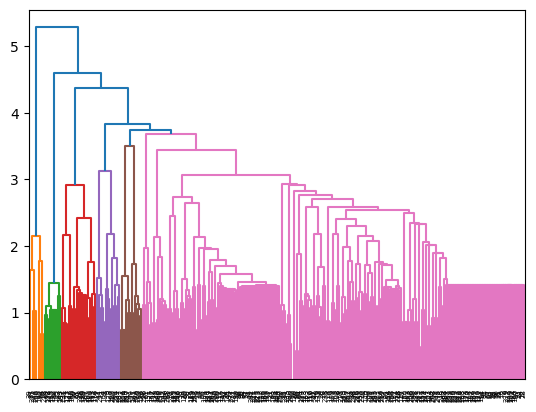

In [198]:
clusters = hierarchy.linkage(csd, method='ward')

dendrogram = hierarchy.dendrogram(clusters, 
                                  labels=list(csd.index), 
                                  orientation="top")

In [202]:
kmeans = KMeans(n_clusters=6).fit_predict(csd)
next_iter['class'] = kmeans
next_iter['class'].value_counts()

0    148
5     90
2     19
4     16
3     10
1      9
Name: class, dtype: int64

In [273]:
history = next_iter.loc[next_iter['class']==2]
history['class'] = history['class'].replace({2: 'История'})
history

,title,class
id,,
110198,Теория и история астрологии,История
110157,История,История
110391,История Средних веков и Возрождения,История
110317,История философии,История
110411,История военного дела,История
110339,История искусств. Искусствоведение,История
110398,История России XIX - нач. XX веков (до 1918 г.),История
110343,История изобразительного искусства,История
110392,История Нового и Новейшего времени (середина X...,История


In [107]:
data[data['title']=='Мастер и Маргарита']

,id,title,author,category,description,publisher,rating,votes
419,2982861,Мастер и Маргарита,596497,110003,"Бессмертное, загадочное и остроумное ""Евангели...",118732,4.179688,45
442,2986107,Мастер и Маргарита,596497,110003,"Бессмертное, загадочное и остроумное ""Евангели...",112078,4.609375,23
683,2765582,Мастер и Маргарита,596497,110003,Роман Михаила Булгакова «Мастер и Маргарита» с...,154486,4.191406,221
2591,2851438,Мастер и Маргарита,596497,110003,Роман «Мастер и Маргарита» - одно из ярчайших ...,118732,4.230469,96
2616,3023074,Мастер и Маргарита,596497,110003,Серия «Элегантная русская классика» предлагает...,154486,4.000000,2
...,...,...,...,...,...,...,...,...
442078,2980525,Мастер и Маргарита,596497,110003,"Москвичи 1930-х годов и свита дьявола, прокура...",135192,4.171875,179
442179,3018590,Мастер и Маргарита,596497,110003,Самая ожидаемая кинопремьера начала 2024 года ...,154486,4.679688,38
442496,3025947,Мастер и Маргарита,596497,110003,"Роман в суперобложке, посвященной выходу фильм...",135192,4.500000,20
443891,2813682,Мастер и Маргарита,596497,110003,Роман Михаила Булгакова «Мастер и Маргарита» с...,154486,4.171875,135


In [275]:
langs = next_iter.loc[next_iter['class']==1]
langs['class'] = langs['class'].replace({1: 'Языки'})
langs

,title,class
id,,
110152,Русский язык,Языки
110153,Английский язык,Языки
110146,Иностранный язык в начальной школе,Языки
110143,Русский язык в начальной школе,Языки
110084,Английский язык,Языки
110083,Русский язык,Языки
110087,Испанский язык,Языки
110086,Французский язык,Языки
110085,Немецкий язык,Языки


In [213]:
wtf = next_iter.loc[next_iter['class']==5]
wtf

,title,class
id,,
110011,Детективный роман. Триллер,5
110205,Пророки. Предсказания,5
110336,"Психология личности. Характер, темперамент, та...",5
110208,Популярные системы сохранения здоровья. Здоров...,5
110337,"Психология успеха. Личная эффективность, мотив...",5
...,...,...
110114,Эксперименты. Фокусы,5
110284,Автоматика. Радиоэлектроника. Связь,5
110263,Охота. Рыбалка. Сбор грибов и ягод,5


In [276]:
laws = next_iter.loc[next_iter['class']==3]
laws['class'] = laws['class'].replace({3: 'Право'})
laws

,title,class
id,,
110430,Конституция и конституционный строй. Конституц...,Право
110436,Предпринимательское право. Торговое (коммерчес...,Право
110438,Потребительское право,Право
110440,Трудовое право,Право
110431,Административное право,Право
110437,Гражданско-процессуальное право. Арбитражно-пр...,Право
110444,Уголовное и уголовно-процессуальное право,Право
110441,Финансовое право,Право
110442,Аграрное и земельное право. Экологическое право,Право


In [278]:
fantasy = next_iter.loc[next_iter['class']==4]
fantasy['class'] = fantasy['class'].replace({4: 'Фентези и Фантастика'})
fantasy

,title,class
id,,
110005,Фэнтези,Фентези и Фантастика
110094,Фантастика и фэнтези для детей,Фентези и Фантастика
110008,Научная фантастика,Фентези и Фантастика
110130,Психология воспитания и обучения детей,Фентези и Фантастика
110095,Повести и рассказы для детей,Фентези и Фантастика
110034,Молодежная фантастика и фэнтези,Фентези и Фантастика
110120,Комиксы и манга для детей,Фентези и Фантастика
110129,Медицина для родителей,Фентези и Фантастика
110275,Атласы и путеводители для туристов,Фентези и Фантастика


In [279]:
next_iter_diff_next = next_iter.loc[next_iter['class']==0]
next_iter_diff_next

,title,class
id,,
0,ND,0
110028,Публицистика,0
110020,Деятели культуры и искусства,0
110002,Современная проза,0
110016,Любовные романы,0
...,...,...
110413,Оружие,0
110255,Домоводство,0
110286,Гражданское и промышленное строительство,0


In [223]:
csd_1 = cos_sim_df(next_iter_diff_next['title'])

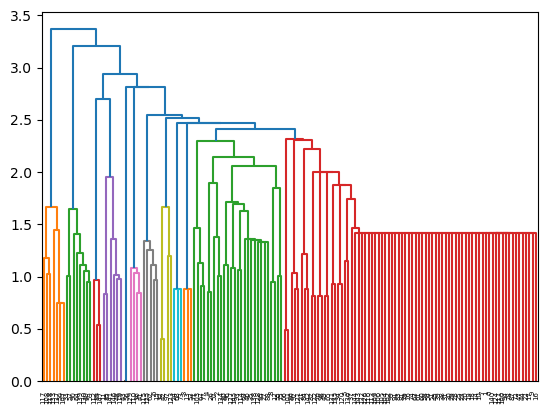

In [224]:
clusters = hierarchy.linkage(csd_1, method='ward')

dendrogram = hierarchy.dendrogram(clusters, 
                                  labels=list(csd_1.index), 
                                  orientation="top")

In [284]:
kmeans = KMeans(n_clusters=11).fit_predict(csd_1)
next_iter_diff_next['class'] = kmeans
next_iter_diff_next['class'].value_counts()

0     89
7     16
3      9
4      7
1      6
10     4
6      4
5      4
9      3
2      3
8      3
Name: class, dtype: int64

In [285]:
hobbies1 = next_iter_diff_next.loc[next_iter_diff_next['class']==0]
hobbies1['class'] = hobbies1['class'].replace({0: 'Хобби'})
hobbies1

,title,class
id,,
0,ND,Хобби
110028,Публицистика,Хобби
110016,Любовные романы,Хобби
110027,Биографии других известных людей,Хобби
110125,Обучение счету,Хобби
...,...,...
110190,Учение Ошо,Хобби
110214,Внутренние болезни,Хобби
110113,Сборники игр,Хобби


In [287]:
detective = next_iter_diff_next.loc[next_iter_diff_next['class']==2]
detective['class'] = detective['class'].replace({2: 'Детектив'})
detective

,title,class
id,,
110012,Исторический детектив,Детектив
110015,Иронический детектив,Детектив
110096,Детский детектив,Детектив


In [289]:
hobbies3 = next_iter_diff_next.loc[next_iter_diff_next['class']==3]
hobbies3['class'] = hobbies3['class'].replace({3: 'Хобби'})
hobbies3

,title,class
id,,
110344,Больше об изобразительном искусстве,Хобби
110378,Больше о предпринимательстве,Хобби
110446,Больше об уголовном праве и криминалистике,Хобби
110439,Больше о гражданском праве,Хобби
110348,"Больше о театре, кино и ТВ",Хобби
110415,О военном деле и спецслужбах,Хобби
110231,Больше о красоте и моде,Хобби
110281,О других видах транспорта,Хобби
110365,Больше о мотивации и личной эффективности,Хобби


In [291]:
hobbies4 = next_iter_diff_next.loc[next_iter_diff_next['class']==4]
hobbies4['class'] = hobbies4['class'].replace({4: 'Хобби'})
hobbies4

,title,class
id,,
110237,Поваренные книги. Сборники рецептов,Хобби
110108,Книги с наклейками,Хобби
110118,Книги с пазлами,Хобби
110119,Тактильные книги,Хобби
110243,Книги о кулинарии,Хобби
110117,Музыкальные книги,Хобби
110448,Книги с автографами,Хобби


In [293]:
other_1 = next_iter_diff_next.loc[next_iter_diff_next['class']==5]
other_1['class'] = other_1['class'].replace({5: 'Другие жанры'})
other_1

,title,class
id,,
110325,Общая теория социальной психологии,Другие жанры
110322,Основы психологии,Другие жанры
110387,Общая теория маркетинга и рекламы,Другие жанры
110294,Общая биология,Другие жанры


In [295]:
other_2 = next_iter_diff_next.loc[next_iter_diff_next['class']==6]
other_2['class'] = other_2['class'].replace({6: 'Другие жанры'})
other_2

,title,class
id,,
110224,Научно-популярная медицинская литература,Другие жанры
110151,Литература,Другие жанры
110121,Детская религиозная литература,Другие жанры
110036,Другая молодежная литература,Другие жанры


In [303]:
school1 = next_iter_diff_next.loc[next_iter_diff_next['class']==7]
school1['class'] = school1['class'].replace({7: 'Школа, учеба'})
school1

,title,class
id,,
110020,Деятели культуры и искусства,"Школа, учеба"
110161,Математика в основной и средней школе,"Школа, учеба"
110351,Сольфеджио и диктанты,"Школа, учеба"
110300,Языки и среды программирования,"Школа, учеба"
110379,Организационный и производственный менеджмент,"Школа, учеба"
110023,Исторические и общественные деятели,"Школа, учеба"
110298,Общенаучное знание и теории,"Школа, учеба"
110323,Психологические школы и направления,"Школа, учеба"
110098,Стихи и песни,"Школа, учеба"


In [308]:
school2 = next_iter_diff_next.loc[next_iter_diff_next['class']==8]
school2['class'] = school2['class'].replace({8: 'Школа, учеба'})
school2

,title,class
id,,
110175,Подготовка к ВПР,"Школа, учеба"
110278,Подготовка к экзамену в ГИБДД,"Школа, учеба"
110174,Подготовка к ОГЭ,"Школа, учеба"


In [310]:
poems = next_iter_diff_next.loc[next_iter_diff_next['class']==9]
poems['class'] = poems['class'].replace({9: 'Проза'})
poems

,title,class
id,,
110002,Современная проза,Проза
110003,Классическая проза,Проза
110035,Романтическая проза,Проза


In [311]:
school3 = next_iter_diff_next.loc[next_iter_diff_next['class']==10]
school3['class'] = school3['class'].replace({10: 'Школа, учеба'})
school3

,title,class
id,,
110394,Общие работы по всемирной истории,"Школа, учеба"
110401,Общие работы по истории России,"Школа, учеба"
110256,Справочники по домоводству и хобби,"Школа, учеба"
110201,Гадание по рунам,"Школа, учеба"


In [253]:
wtf

,title,class
id,,
110011,Детективный роман. Триллер,5
110205,Пророки. Предсказания,5
110336,"Психология личности. Характер, темперамент, та...",5
110208,Популярные системы сохранения здоровья. Здоров...,5
110337,"Психология успеха. Личная эффективность, мотив...",5
...,...,...
110114,Эксперименты. Фокусы,5
110284,Автоматика. Радиоэлектроника. Связь,5
110263,Охота. Рыбалка. Сбор грибов и ягод,5


In [254]:
csd_2 = cos_sim_df(wtf['title'])

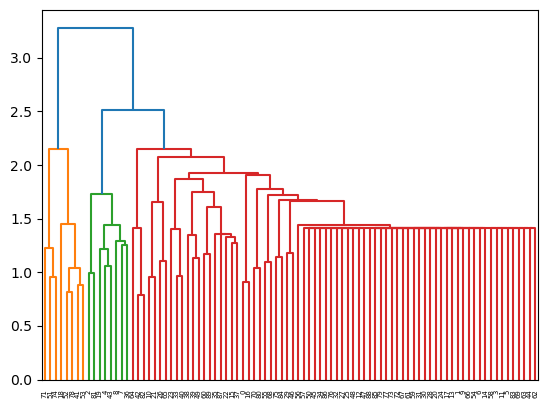

In [255]:
clusters = hierarchy.linkage(csd_2, method='ward')

dendrogram = hierarchy.dendrogram(clusters, 
                                  labels=list(csd_2.index), 
                                  orientation="top")

In [258]:
kmeans = KMeans(n_clusters=5).fit_predict(csd_2)
wtf['class'] = kmeans
wtf['class'].value_counts()

0    58
2    14
1     8
3     7
4     3
Name: class, dtype: int64

In [327]:
o2 = wtf.loc[wtf['class']==0]
o2['class'] = o2['class'].replace({0: 'Другие жанры'})
o2

,title,class
id,,
110011,Детективный роман. Триллер,Другие жанры
110205,Пророки. Предсказания,Другие жанры
110208,Популярные системы сохранения здоровья. Здоров...,Другие жанры
110386,Интернет-маркетинг. Маркетинг в социальных мед...,Другие жанры
110210,Коррекция фигуры. Диеты,Другие жанры
110326,Психотерапия. Психодиагностика,Другие жанры
110202,Карты Таро. Гадание на картах,Другие жанры
110384,Реклама. Копирайтинг. PR. Брендинг,Другие жанры
110007,Мистика. Ужасы,Другие жанры


In [320]:
psyco = wtf.loc[wtf['class']==1]
psyco['class'] = psyco['class'].replace({1: 'Психология'})
psyco

,title,class
id,,
110336,"Психология личности. Характер, темперамент, та...",Психология
110337,"Психология успеха. Личная эффективность, мотив...",Психология
110335,Психология общения. Межличностные коммуникации,Психология
110364,Психология менеджмента. Лидерство. Мотивация. ...,Психология
110327,Глубинная психология. Психоанализ,Психология
110363,Психология бизнеса. Психология успеха. Карьера...,Психология
110382,Общая теория менеджмента. Практические кейсы,Психология
110353,"Нотные издания. Собрания сочинений, партитуры,...",Психология


In [326]:
o3 = wtf.loc[wtf['class']==2]
o3['class'] = o3['class'].replace({2: 'Другие жанры'})
o3

,title,class
id,,
110333,Психология отношений. Семья и брак,Другие жанры
110341,Живопись и графика. Техники и приемы,Другие жанры
110024,Бизнесмены. Истории компаний и брендов,Другие жанры
110274,Подарочные издания о туризме. Фотоальбомы о го...,Другие жанры
110406,Международные отношения. Внешняя политика,Другие жанры
110279,ПДД. Права и обязанности водителя. Штрафы,Другие жанры
110206,Магия и колдовство. Суеверия,Другие жанры
110220,Альтернативная и народная медицина. Советы цел...,Другие жанры
110360,Мировая экономика и международные экономически...,Другие жанры


In [328]:
science1 = wtf.loc[wtf['class']==3]
science1['class'] = science1['class'].replace({3: 'Наука'})
science1

,title,class
id,,
110164,Физика. Астрономия,Наука
110289,Физика. Механика. Научные издания,Наука
110089,Прочие издания по филологии,Наука
110288,Математика. Научные издания,Наука
110290,Астрономия. Научные издания,Наука
110352,Учебные издания по музыке,Наука
110291,Химия. Научные издания,Наука


In [329]:
science2 = wtf.loc[wtf['class']==4]
science2['class'] = science2['class'].replace({4: 'Наука'})
science2

,title,class
id,,
110167,Биология. Экология,Наука
110295,Биология человека. Антропология,Наука
110292,Науки о Земле. Экология,Наука


In [ ]:
genres = pd.concat([])

In [331]:
category[category.index == 110003]

,title,class
id,,
110003,Классическая проза,0


In [337]:
new_categories = pd.concat([books_on_english, other_genres, category_3, history, langs, laws, fantasy, hobbies1, hobbies3,
           hobbies4, other_1, other_2, other_3, school1, school2, school3, poems, o2, psyco, o3, science1, science2
          ])

In [343]:
new_categories.index.value_counts().head(15)

110206    2
110371    2
110263    2
110333    2
110341    2
110024    2
110274    2
110406    2
110279    2
110105    2
110220    2
110360    2
110229    2
110230    2
110020    1
Name: id, dtype: int64

In [345]:
new_categories.iloc[new_categories.index == 110206]

,title,class
id,,
110206,Магия и колдовство. Суеверия,Другие жанры
110206,Магия и колдовство. Суеверия,Другие жанры
